# Learning MRI from simultaneous EEG recordings

<img src="EEGtoMRI.png">

*EEG (avg or FCz referenced) to MRI BOLD translation (MRI with Harvard-Oxford Parcellated based on MNI152 space)*


This notebook details filtering, feature extraction and basic model training for a simple feedforward ANN for predicting MRI BOLD signal from simultaneous EEG recordings. The program uses simple festures such as energy in the delta through to gamma bands as predictors (delta band power has shown to be correlated with cortical BOLD in resting wakefulness). Other possible features include low average frequency IMFs from EMD-based analysis and information theoretic features (e.g. LZ complexity and entropy).

This code was originally designed for real simultaneously aquired EEG/MRI signal from wakeful and anaesthetised subjects. In lieu of real data, pairwise uncorrelated multidimensional pink noise is used to simulate EEG/MRI signal after initial PCA. Other architectures such as RNNs may lead to better performance on real (non-simulated data).

High dimensional MRI data is assumed to have been first registered to a standard space model and then dimensionally reduced by anatomical or functional parcellation. An example of which is shown above (right).

In [1]:
import tensorflow as tf
import mne#a package for analysing EEG data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter,lfilter
from lspopt.lsp import spectrogram_lspopt
import random
import sklearn
import glob
fs=250

#Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut=0.1, highcut=100, fs=fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

/Users/ssackstein/miniforge3/lib/python3.9/site-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
/Users/ssackstein/miniforge3/lib/python3.9/site-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


# Simulated EEG data

In [2]:
import colorednoise as cn
sim_time = 600 #600 seconds of simulated data
beta = 1 # the exponent
eeg_samples = fs*sim_time # number of samples to generate
channels = 10
eeg_data = np.zeros((eeg_samples,channels))
for i in range(channels):
    eeg_data[:,i] = cn.powerlaw_psd_gaussian(beta, eeg_samples)

In [3]:
eeg_data.shape

(150000, 10)

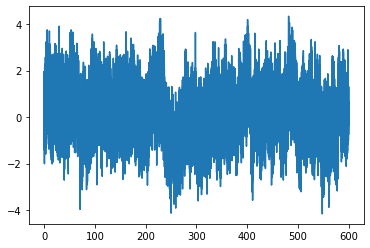

In [4]:
plt.plot(np.arange(0,sim_time,1/fs),eeg_data[:,i])

# Simple feature extraction for EEG data

In [5]:
def get_f_bands(f):
    f_sw = [k for k in range(len(f)) if f[k]<=1.5 and f[k]>0.1]
    #literature suggests a robust correlation between EEG <1.5Hz and cortical MRI
    f_delta = [k for k in range(len(f)) if f[k]>1.5 and f[k]<=4]
    f_theta = [k for k in range(len(f)) if f[k]>4 and f[k]<=8]
    f_alpha = [k for k in range(len(f)) if f[k]>8 and f[k]<=12]
    f_beta = [k for k in range(len(f)) if f[k]>12 and f[k]<=24]
    f_gamma = [k for k in range(len(f)) if f[k]>24]
    f_bands = [f_sw,f_delta,f_theta,f_alpha,f_beta,f_gamma]
    return f_bands

def get_power_data(data,window=2,use_mne=0,r=fs):
    #data - mne readable file (if use_mne) or numpy array (ch_data,ch)
    #window = size of sample window
    #r - moving avg sliding window, default to 1 second
    if use_mne: 
        raw=mne.io.read_raw_brainvision(file,preload=True).resample(fs, npad='auto')
        eeg = raw.copy().pick_types(meg=False, eeg=True, eog=False)
        eeg_data = eeg[:][0]
    else:
        eeg_data = data
    f, t, Sxx = spectrogram_lspopt(eeg_data[:,0], fs=fs,nperseg=window*fs,noverlap=window*fs-1,c_parameter=20)
    f_bands = get_f_bands(f)
    p_len = len(pd.Series(np.sum(Sxx[f_bands[0],:],axis=0)).rolling(r).median()[r-1:])
    power_data = np.zeros((p_len,eeg_data.shape[1]*len(f_bands)))   
    for i in range(eeg_data.shape[1]):
        eeg_data[:,i] = butter_bandpass_filter(eeg_data[:,i])#optional butter bandpass
        f, t, Sxx = spectrogram_lspopt(eeg_data[:,i], fs=fs,nperseg=window*fs,noverlap=window*fs-1,c_parameter=20)
        for b in range(len(f_bands)):
            power_data[:,i*len(f_bands)+b] = pd.Series(np.sum(Sxx[f_bands[b],:],axis=0)).rolling(r).median()[r-1:]
        print('Channel ' + str(i+1)+' done')
    power_data = np.log(power_data)
    return power_data,t[r-1:]

In [6]:
data_list = [eeg_data]#eeg_data or list of files
power_data = []
t_data = []
for data in data_list:
    p,t=get_power_data(data)
    t_data.append(t)
    power_data.append(p)

Channel 1 done
Channel 2 done
Channel 3 done
Channel 4 done
Channel 5 done
Channel 6 done
Channel 7 done
Channel 8 done
Channel 9 done
Channel 10 done


In [7]:
power_data[0].shape

(149252, 60)

In [8]:
power_data

[array([[-0.86540721, -1.53201955, -2.45511127, ..., -2.5720634 ,
         -2.28049635, -1.40464722],
        [-0.86018842, -1.52740019, -2.45511127, ..., -2.57153016,
         -2.28049635, -1.40257111],
        [-0.85620094, -1.52309905, -2.45511127, ..., -2.57101604,
         -2.28049635, -1.40047747],
        ...,
        [-0.73973525, -1.95975506, -2.68961598, ..., -2.26108243,
         -2.35551283, -1.47578495],
        [-0.74003565, -1.96232837, -2.68961598, ..., -2.26108243,
         -2.35551283, -1.476085  ],
        [-0.7408043 , -1.96540495, -2.68961598, ..., -2.26108243,
         -2.35551283, -1.47638169]])]

# Marker extraction code (if they exists)

In [9]:
#raw=mne.io.read_raw_brainvision(EEG_files[0],preload=True)
#annot = mne.read_annotations('mark_test.vmrk')
#raw.set_annotations(annot)

annot = mne.read_annotations(EEG_mark[1],1000)
annot

# Simulation code

In [10]:
#encode some MRI data into EEGimport colorednoise as cn
fs_MRI = 0.5
beta = 0.2 # the colored noise exponent
MRI_samples = int(fs_MRI*sim_time) # number of samples to generate (5 minutes of data)
rois = 20
MRI_data = np.zeros((MRI_samples,rois))
for i in range(rois):
    MRI_data[:,i] = cn.powerlaw_psd_gaussian(beta, MRI_samples)
t_vec = (t_data[0]*fs).astype('int')
MRI_data = np.repeat(MRI_data, 1/fs_MRI*fs,axis=0)
MRI_data = MRI_data[t_vec,:]
MRI_data = np.log(MRI_data-np.min(MRI_data)+1e-6)#mitigate effects of outliers
low_bands = list(np.arange(0,power_data[0].shape[1],6))+list(np.arange(1,power_data[0].shape[1],6))
MRI_data[:,0] += np.mean(power_data[0][:,low_bands],axis=1)*0.8#encode some MRI data into EEG
MRI_data[:,1] += np.mean(power_data[0][:,low_bands],axis=1)*0.8

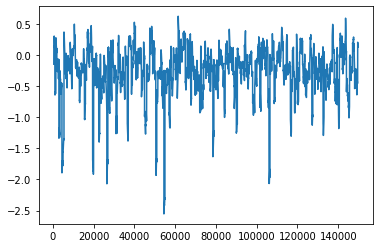

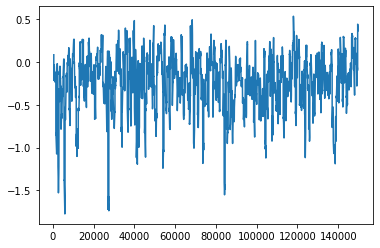

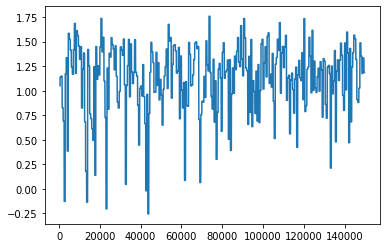

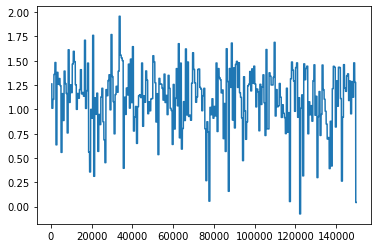

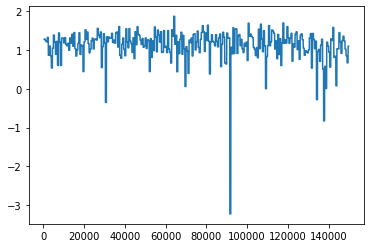

In [11]:
#show the first n simulated time series
for i in range(5):
    plt.plot(t_vec,MRI_data[:,i])
    plt.show()

# Real MRI data extraction code

In [12]:
#MRI_list = [MRI_data]#change these to location of MRI csv file

In [13]:
def get_MRI_data(fs_MRI=3):
    MRI_data = []
    for i in range(len(MRI_list)):
        t_vec = (t_data[i]*fs).astype('int')
        MRI=pd.read_csv(MRI_files[i],header=None,sep=' ')
        cols = [0]
        MRI.drop(MRI.columns[cols],axis=1,inplace=True)
        MRI = np.log(np.array(MRI))
        MRI= np.repeat(MRI, 1/fs_MRI*fs,axis=1).transpose()
        MRI = MRI[t_vec,:]
        MRI-=np.mean(MRI,axis=0)
        MRI/=np.std(MRI,axis=0)
        MRI_data.append(MRI)
    return MRI_data

In [14]:
#MRI_data = get_MRI_data()

# Randomise training, validation and testing sets

An important point is that because of temporal dependence data cannot be sampled independently for creating validation and testing sets. We choose a compromise which segments data into a |training|validation|test| set with a random boundary between validation and training data.

In [15]:
MRI_data = [MRI_data]#change these to location of MRI csv file

In [16]:
def rand_parts(seq, val_len,test_len):
    #creates test and validation index sets
    test_val_len = val_len+test_len
    indices = range(len(seq) - (test_val_len - 1))
    result = []
    offset = 0
    s = random.sample(indices, 1)[0]    
    result.append(seq[s:s+val_len])
    result.append(seq[s+val_len:s+val_len+test_len])
    return result

In [17]:
from sklearn.preprocessing import scale
test_val_frac = 0.2
test_inds = []
power_test = []
power_train = []
power_val = []
MRI_test = []
MRI_val = []
MRI_train = []
for i in range(len(MRI_data)):
    inds = (t_data[i]*fs).astype(int)
    test_val_size = int(len(t_data[i])*test_val_frac)
    tv_inds = rand_parts(inds,test_val_size,test_val_size)
    power_test.append(scale(power_data[i][tv_inds[0],:]))
    power_val.append(scale(power_data[i][tv_inds[1],:]))
    power_train.append(scale(np.array([power_data[i][k,:] for k,x in enumerate(t_data[i]) 
                                 if k not in tv_inds[0] and k not in tv_inds[1]])))
    MRI_test.append(scale(MRI_data[i][tv_inds[0],:]))
    MRI_val.append(scale(MRI_data[i][tv_inds[1],:]))
    MRI_train.append(scale(np.array([MRI_data[i][k,:] for k,x in enumerate(t_data[i]) 
                                 if k not in tv_inds[0] and k not in tv_inds[1]])))

In [18]:
#concatenate all data sets for model training/testing/validation
power_train = np.concatenate(power_train)
MRI_train = np.concatenate(MRI_train)
power_val = np.concatenate(power_val)
MRI_val = np.concatenate(MRI_val)
power_test = np.concatenate(power_test)
MRI_test = np.concatenate(MRI_test)

In [19]:
#Optionally train only on low frequency EEG bands
power_train = power_train[:,low_bands]
power_val = power_val[:,low_bands]
power_test = power_test[:,low_bands]

## CNN model

In [20]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, input_shape=(power_train.shape[1],),activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(MRI_train.shape[1],activation="linear"))
l = tf.keras.losses.LogCosh()
model.compile(optimizer='Adam', loss=l)

Metal device set to: Apple M1 Pro


2022-04-27 21:15:09.426685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 21:15:09.426789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
random.seed(10062020)
model.fit(power_train, MRI_train, batch_size=128, epochs=5)

Epoch 1/5


2022-04-27 21:15:09.542459: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-27 21:15:09.694113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


701/701 [==============================] - 4s 5ms/step - loss: 0.3050
Epoch 2/5
701/701 [==============================] - 4s 5ms/step - loss: 0.2699
Epoch 3/5
701/701 [==============================] - 4s 6ms/step - loss: 0.2525
Epoch 4/5
701/701 [==============================] - 4s 6ms/step - loss: 0.2410
Epoch 5/5
701/701 [==============================] - 4s 6ms/step - loss: 0.2328


In [22]:
y_pred=model.predict(power_train)
y = MRI_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

2022-04-27 21:15:29.649903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(0.16686954, shape=(), dtype=float32)
[[1.         0.78525962]
 [0.78525962 1.        ]]


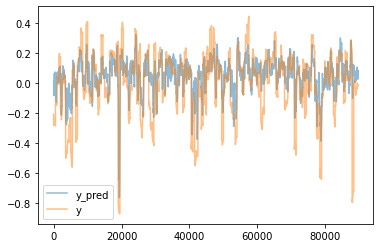

In [23]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

## LSTM Model 

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=power_train.shape[1], output_dim=64))
model.add(LSTM(64))
model.add(tf.keras.layers.Dense(128, input_shape=(power_train.shape[1],),activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(MRI_train.shape[1],activation="linear"))
#l = tf.keras.losses.BinaryCrossentropy()
l = tf.keras.losses.LogCosh()
model.compile(optimizer='Adam', loss=l)


In [25]:
model.fit(power_train, MRI_train, batch_size=128, epochs=5)

Epoch 1/5


2022-04-27 21:15:34.563686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-27 21:15:34.723603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  4/701 [..............................] - ETA: 14s - loss: 0.3410 

2022-04-27 21:15:34.831838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


701/701 [==============================] - 13s 17ms/step - loss: 0.3255
Epoch 2/5
 14/701 [..............................] - ETA: 12s - loss: 0.3105

KeyboardInterrupt: 

In [ ]:
y_pred=model.predict(power_train)
y = MRI_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
#print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

In [ ]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

## RNN model 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Embedding(input_dim=power_train.shape[1], output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))
model.add(tf.keras.layers.Dense(128, input_shape=(power_train.shape[1],),activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(MRI_train.shape[1],activation="linear"))
l = tf.keras.losses.LogCosh()
model.compile(optimizer='Adam', loss=l)

In [ ]:
model.fit(power_train, MRI_train, batch_size=128, epochs=5)

In [ ]:
model.save('./modelRNN')

In [ ]:
y_pred=model.predict(power_train)
y = MRI_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
#print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

In [ ]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

## Graph CNN 

In [26]:
import torch
power_train[:20,:4]
torch.tensor(power_train[:20,:], dtype=torch.float).shape, MRI_train[:20,:].shape

(torch.Size([20, 20]), (20, 20))

In [27]:
edge_index= torch.tensor([[ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,
          3,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13,
         13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17,
         17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19],
        [10,  6, 13,  1,  0,  5, 16,  0, 16,  1, 14, 10,  8,  2,  5,  8, 15, 12,
          9, 10,  3,  4, 13,  0, 10,  2,  5,  0, 16,  6, 14, 13, 11, 18,  7, 17,
         11, 18,  3,  2, 15,  8, 10,  9, 13,  3, 12, 10,  5,  9,  8,  3, 10,  2,
         13,  0,  6, 11,  7, 13, 18,  3,  9, 13, 12, 13,  9,  6,  4, 12,  0, 11,
         10, 18, 19,  1, 14,  6, 16,  3, 15,  8, 16, 14,  1,  0,  6,  7, 19, 17,
         18, 14, 18, 17,  7,  6, 19, 11, 18, 14, 19, 17]])

In [28]:
edge_attr =torch.tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from tqdm import tqdm
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

#loader = ChickenpoxDatasetLoader()

#dataset = loader.get_dataset()

#train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)


model = RecurrentGCN(node_features = 20)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
time=0
#for epoch in tqdm(range(sim_time)):
cost = 0

y_hat = model(torch.tensor(power_train[:,:], dtype=torch.float), edge_index,edge_attr)
cost = cost + torch.mean((y_hat-torch.tensor(MRI_train[:,:], dtype=torch.float))**2)
cost = cost 
time+=1
cost.backward()
optimizer.step()
optimizer.zero_grad()
model.eval()


RecurrentGCN(
  (recurrent): DCRNN(
    (conv_x_z): DConv(52, 32)
    (conv_x_r): DConv(52, 32)
    (conv_x_h): DConv(52, 32)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [30]:
y_hat.detach().numpy().shape,MRI_train[:,:1].shape

((89668, 1), (89668, 1))

In [31]:
#cost = 0

#y_hat = model(torch.tensor(power_train[:,:], dtype=torch.float), edge_index, edge_attr)
#cost = cost + torch.mean((y_hat-torch.tensor(MRI_train[:,:], dtype=torch.float))**2)
#cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.0312


In [ ]:
y_pred=y_hat.detach().numpy()
y = MRI_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)

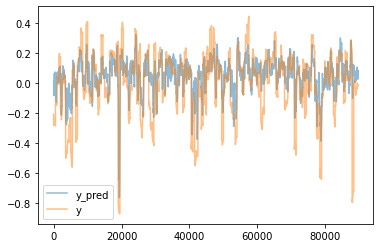

In [39]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

In [ ]:
power_train_graph = power_train.flatten()

In [ ]:
power_train_mean = np.mean(power_train,axis=1)
power_train_mean.shape

In [ ]:
for i in range(len(G.nodes)):
    G.nodes[i]["label"]  = power_train_graph[i]

In [ ]:
from networkx.algorithms import node_classification

G.nodes(data=True)

G.edges()

#predicted = node_classification.harmonic_function(G)
#predicted

In [ ]:
zkc=G
order = sorted(list(zkc.nodes()))
A = nx.to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
A = nx.to_numpy_array(zkc, nodelist=order)
A_hat = A + np.eye(zkc.number_of_nodes())
D_hat = np.diag(np.sum(A_hat, axis=1))
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 20))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))


In [ ]:
import numpy as np
import pandas as pd
import h5py
import os
import time
from scipy.stats import skew, kurtosis
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler

import torch
from torch_geometric.data import InMemoryDataset, Data
from torch.nn import Linear
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F 
from torch_geometric.nn import TopKPooling, global_mean_pool, ChebConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader
import torch.backends.cudnn as cudnn
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools


In [ ]:

from torch.nn import ReLU



def relu(x):
    return np.maximum(x, 0)

def gcn_layer(A_hat, D_hat, X, W):
    return relu(np.linalg.inv(D_hat) @ A_hat @ X @ W)

H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2

plt.scatter(H_2[:,0], H_2[:,1])

In [ ]:
output.shape

In [ ]:
MRI_train_graph = MRI_train.flatten()

In [ ]:
MRI_train_graph = MRI_train_graph[:9000]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=output.shape[1], output_dim=900))
model.add(LSTM(900))
model.add(tf.keras.layers.Dense(128, input_shape=(output.shape[1],),activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(MRI_train.shape[0],activation="linear"))
#l = tf.keras.losses.BinaryCrossentropy()
l = tf.keras.losses.LogCosh()
model.compile(optimizer='Adam', loss=l)

In [ ]:
model.fit(output,MRI_train[:9000,:], batch_size=128, epochs=5)

In [ ]:
y_pred=model.predict(output)

#print(l(y,y_pred))
print(np.corrcoef(output,MRI_train_graph))

In [ ]:
H_1.shape

In [ ]:
y_pred_g.shape

In [ ]:
G = nx.path_graph(90106)

for i in range(len(G.nodes)):
    G.nodes[i]["label"]  = np.mean(y_pred_g[i])

In [ ]:
from networkx.algorithms import node_classification

G.nodes(data=True)

G.edges()

predicted = node_classification.harmonic_function(G)
predicted

In [ ]:
zkc=G
order = sorted(list(zkc.nodes()))
A = to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
A = to_numpy_array(zkc, nodelist=order)
A_hat = A + np.eye(zkc.number_of_nodes())
D_hat = np.diag(np.sum(A_hat, axis=1))
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 20))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))


In [ ]:
from torch.nn import ReLU



def relu(x):
    return np.maximum(x, 0)

def gcn_layer(A_hat, D_hat, X, W):
    return relu(np.linalg.inv(D_hat) @ A_hat @ X @ W)

H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2

plt.scatter(H_2[:,0], H_2[:,1])

In [ ]:
plt.plot(y_pred,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

In [ ]:
y_pred=output[:,1]
y_pred_mean=np.mean(y_pred)
y_meanx = np.mean(y)

100-(y_pred_mean-y_meanx)

In [ ]:
y_pred.shape

In [ ]:
output.shape

In [ ]:
y_mean = np.mean(y,axis=1)

In [ ]:
y_mean

In [ ]:
y_pred=np.mean(output,axis=1)

In [ ]:
output.shape

In [ ]:
y_mean.shape

In [ ]:
y=MRI_train

y_mean = np.mean(y,axis=1)


In [ ]:
output

In [ ]:
plt.plot(np.mean(output,axis=1),label='y_pred',alpha=0.2)
plt.plot(abs(np.mean(y[:9000],axis=1)),label='y',alpha=0.2)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

In [ ]:
np.array(f)

In [ ]:
output

In [ ]:
MRI_train[1:21].shape

In [ ]:
power_train[0].shape

In [ ]:
torch.Tensor(MRI_train)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.conv1 = ChebConv(power_train.shape[1], 32, K=3)
        self.conv2 = ChebConv(32, 64, K=4)
        self.conv3 = ChebConv(64, 128, K=5)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.bn3 = torch.nn.BatchNorm1d(128)

        # Output layer
        self.dense = Linear(128,MRI_train.shape[1])

    def forward(self, x, edge_index):

        # Conv layers
        hidden = self.conv1(x, edge_index)
        hidden = self.bn1(hidden)
        hidden = F.relu(hidden)
        
        hidden = self.conv2(hidden, edge_index)
        hidden = self.bn2(hidden)
        hidden = F.relu(hidden)
        
        hidden = self.conv3(hidden, edge_index)
        hidden = self.bn3(hidden)
        hidden = F.relu(hidden)
        
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden), 
                            gap(hidden)], dim=1)
        
        # Apply a final (linear) classifier.
        hidden = self.dense(hidden)

        return F.log_softmax(hidden, dim=1)

In [ ]:
def train():
    model.train()
    running_loss = 0
    accuracy = 0
    for batch in trainloader:
        # Use GPU
        batch.cuda() 
        # Reset gradients
        optimizer.zero_grad()
        # Passing the node features and the connection info
        pred = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.flatten()) 
        # Calculating the loss and gradients
        loss = criterion(pred, batch.y)
        loss.backward()
        running_loss += loss.item()
        # Update using the gradients
        optimizer.step()
        accuracy += (torch.argmax(pred, dim=1) == batch.y).float().mean()
    return running_loss/len(trainloader), accuracy/len(trainloader)

In [ ]:
ChebConv(43,2,K=3)

In [ ]:
model = GCN()
print(model)


In [ ]:
torch.Tensor(MRI_train[0])

In [ ]:
torch.Tensor([[i] for i in power_train[0]])

In [ ]:
MRI_train[0]

# Simple models based on simulated data does not generalise well
The model based on simulated data does not generalise well.

In [ ]:
y_pred=model.predict(power_val)
y = MRI_val
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

In [ ]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

# Cortical MRI ROI Only Fitting

This model is based on real cortical MRI ROIs from the Harvard-Oxford cortical parcellation.

In [ ]:
cort_train = MRI_train[:,:48]
cort_val = MRI_val[:,:48]
cort_test = MRI_test[:,:48]
sub_train = MRI_train[:,48:]
sub_val = MRI_val[:,48:]
sub_test = MRI_test[:,48:]

In [ ]:

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(128, input_shape=(cort_train.shape[1],),activation="relu"))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(128,activation="relu"))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(sub_train.shape[1],activation="linear"))
l = tf.keras.losses.LogCosh()
model2.compile(optimizer='Adam', loss=l)

In [ ]:
random.seed(10062020)
model2.fit(cort_train, sub_train, batch_size=128, epochs=30)

In [ ]:
model2.save('/MRI/model2')

In [ ]:
model2 = tf.keras.models.load_model('/MRI/model2')

In [ ]:
y_pred=cort_train
y = sub_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
# print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

In [ ]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

In [ ]:
y_pred=model2.predict(cort_val)
y = sub_val
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

In [ ]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

In [ ]:
i=1
y_pred=model.predict(power_test)[:,i]
y=MRI_test[:,i]
plt.plot(y_pred,label='y_pred')
plt.plot(y,label='y')
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

In [ ]:
np.corrcoef(y_pred,y)

# Conclusion

Real data generalises marginally better than simulated MRI/EEG data based on mostly uncorrelated colored noise. More sophisticated models e.g. deep RNNs may help to generalise further.